# Lip Reading Viseme Data with a CNN
# Artificial & Biological Vision Final Project
## NEUR 189B, Spring 2025
### Blake Buckner

In this project, I set out to use Convolutional Neural Networks to create a system for lip reading using only visual data. Below is my target pipeline, which was slightly altered due to limitations but remains mostly accurate to the actual implementation. I ended up changing a lot through the process and went back and forth with ideas, which has probably left some deprecated portions I missed.

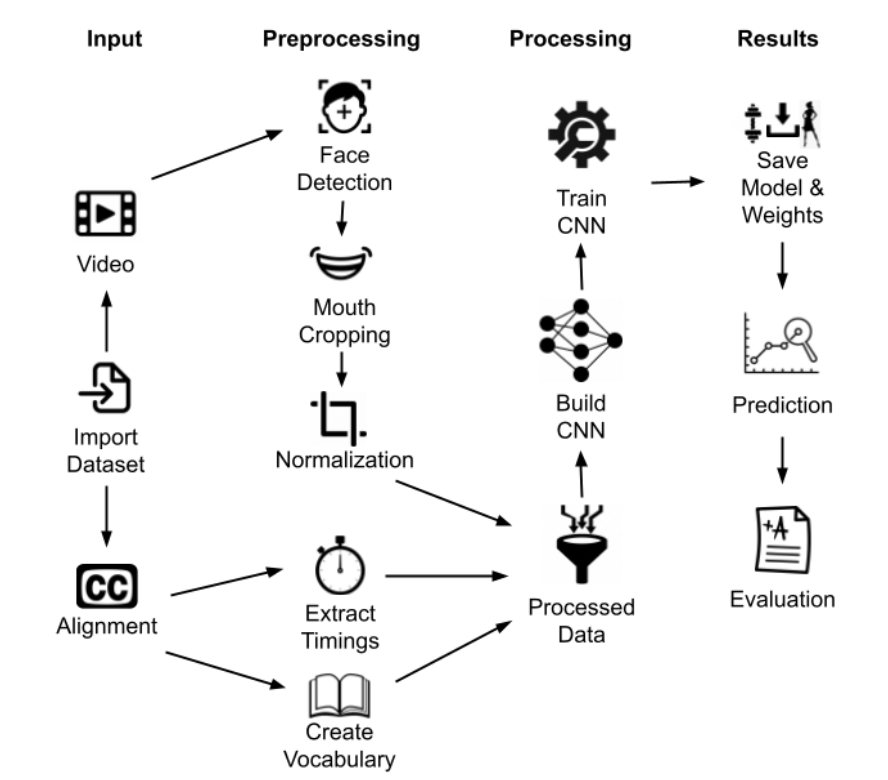

## Innitialization and Dataloading

In [3]:
!pip install mediapipe
!pip install --upgrade numpy

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling 

In [4]:
import os, cv2, re
import numpy as np
import pandas as pd
import mediapipe as mp
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import cmudict
import random
import nltk
import glob


In [5]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jedidiahangekouakou/grid-corpus-dataset-for-training-lipnet")

data_path = f"{path}/data/s1_processed"
alignment_path = f"{data_path}/align"

In [6]:
# Link for the phoneme viseme map csv needed for alignment
# https://drive.google.com/file/d/1b-2nigeYNnFLyctHLZysWounasLINmga/view?usp=sharing

nltk.download('cmudict')
cmu = cmudict.dict()
arpabet_to_viseme = pd.read_csv("phoneme-viseme_map.csv").set_index("Arpabet 2-letter")["Viseme"].to_dict()

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [7]:
# Constants
FRAME_W = 80
FRAME_H = 40

TOTAL_VISEMES = 16

# Define some dataloading constants
SEED = 42
SAMPLE_SIZE = 200
TRAINING_SIZE = 0.8

# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001

In [8]:
# Encoding the visemes as integers
unique_visemes = list(set(arpabet_to_viseme.values()))
unique_visemes = [v for v in unique_visemes if v.strip()]  # Remove empty or whitespace entries
encode_visemes = {viseme: idx for idx, viseme in enumerate(unique_visemes)}
decode_visemes = {idx: viseme for viseme, idx in encode_visemes.items()}

In [9]:
def word_to_phonemes(word):
    phonemes = cmu.get(word.lower(), [])
    return phonemes[0] if phonemes else []  # Select the first pronunciation

def phoneme_to_viseme(ph_with_stress):
    ph = re.sub(r"\d+$", "", ph_with_stress)  # Remove digit stress marker
    return arpabet_to_viseme.get(ph, None)

In [10]:
# Print the visemes and their encodings
for visemes in range(TOTAL_VISEMES):
  decoded_viseme = decode_visemes.get(visemes, "Unknown")

  print(f"Encoded {visemes} -> Decoded '{decoded_viseme}'")

Encoded 0 -> Decoded 'E'
Encoded 1 -> Decoded 'f'
Encoded 2 -> Decoded 'r'
Encoded 3 -> Decoded 'e'
Encoded 4 -> Decoded 't'
Encoded 5 -> Decoded 's'
Encoded 6 -> Decoded 'S'
Encoded 7 -> Decoded 'O'
Encoded 8 -> Decoded 'o'
Encoded 9 -> Decoded 'T'
Encoded 10 -> Decoded 'u'
Encoded 11 -> Decoded 'i'
Encoded 12 -> Decoded 'k'
Encoded 13 -> Decoded 'a'
Encoded 14 -> Decoded 'p'
Encoded 15 -> Decoded '@'


In [11]:
# Print the phonemes and their mapped viseme
for phoneme, viseme in arpabet_to_viseme.items():
    print(f"Phoneme: {phoneme} -> Viseme: {viseme}")

Phoneme: AX -> Viseme: @
Phoneme: AE -> Viseme: a
Phoneme: AA -> Viseme: a
Phoneme: AA  -> Viseme: a
Phoneme: AW -> Viseme: a
Phoneme: AY -> Viseme: a
Phoneme: EH -> Viseme: E
Phoneme: AH -> Viseme: E
Phoneme: ER -> Viseme: E
Phoneme: nan -> Viseme:  
Phoneme: EY -> Viseme: e
Phoneme: F -> Viseme: f
Phoneme: V -> Viseme: f
Phoneme: Y -> Viseme: i
Phoneme: IH -> Viseme: i
Phoneme: IY -> Viseme: i
Phoneme: G -> Viseme: k
Phoneme: HH -> Viseme: k
Phoneme: K -> Viseme: k
Phoneme: NG -> Viseme: k
Phoneme: OW -> Viseme: o
Phoneme: AO -> Viseme: O
Phoneme: OY -> Viseme: O
Phoneme: B -> Viseme: p
Phoneme: M -> Viseme: p
Phoneme: P -> Viseme: p
Phoneme: R -> Viseme: r
Phoneme: JH -> Viseme: S
Phoneme: ZH -> Viseme: S
Phoneme: SH -> Viseme: S
Phoneme: CH -> Viseme: S
Phoneme: Z -> Viseme: s
Phoneme: S -> Viseme: s
Phoneme: D -> Viseme: t
Phoneme: L -> Viseme: t
Phoneme: N -> Viseme: t
Phoneme: T -> Viseme: t
Phoneme: DH -> Viseme: T
Phoneme: TH -> Viseme: T
Phoneme: W -> Viseme: u
Phoneme: UH ->

In [12]:
def load_alignment(path):
    df = pd.read_csv(path, header=None, names=["start", "end", "word"], sep=r"\s+")
    return df[df["word"] != "sil"]

def process_alignment(path, fps=25, total_frames=75, audio_sampling_rate=25000):
    df = load_alignment(path)
    df["arpabet"] = df["word"].apply(word_to_phonemes)
    df["visemes"] = df["arpabet"].apply(lambda phonemes: [phoneme_to_viseme(ph) for ph in phonemes])
    df["encoded_visemes"] = df["visemes"].apply(lambda visemes: [encode_visemes.get(v, -1) for v in visemes])
    df["start_frame"] = (df["start"] / audio_sampling_rate * fps).astype(int)
    df["end_frame"] = (df["end"] / audio_sampling_rate * fps).astype(int)
    return df

Next we need the video preprocessing

In [13]:
# Landmarks for lips in facial recognition
MOUTH_LANDMARKS = [
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291,
    78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308
]

In [14]:
def expand_bbox_to_aspect_ratio(x, y, w, h, target_ar, frame_width, frame_height):
    cur_ar = w / h
    if cur_ar < target_ar:
        # Need wider box -> increase width
        new_w = int(h * target_ar)
        dw = new_w - w
        x_new = max(x - dw // 2, 0)
        if x_new + new_w > frame_width:
            x_new = frame_width - new_w
        return int(x_new), int(y), int(new_w), int(h)
    else:
        # Need taller box -> increase height
        new_h = int(w / target_ar)
        dh = new_h - h
        y_new = max(y - dh // 2, 0)
        if y_new + new_h > frame_height:
            y_new = frame_height - new_h
        return int(x), int(y_new), int(w), int(new_h)


In [15]:
def extract_mouth_sequence(video_path, pad=5, resize_to=(FRAME_W, FRAME_H), insert_blank_on_fail=True):
    mp_face_mesh = mp.solutions.face_mesh

    mouth_frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file {video_path}")

    with mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as face_mesh:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            height, width, _ = frame.shape
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)

            if not results.multi_face_landmarks:
                if insert_blank_on_fail:
                    blank_frame = np.zeros((resize_to[1], resize_to[0], 3), dtype=np.uint8)
                    mouth_frames.append(blank_frame)
                continue

            face_landmarks = results.multi_face_landmarks[0]
            mouth_points = []
            for idx in MOUTH_LANDMARKS:
                lm = face_landmarks.landmark[idx]
                x_px = int(lm.x * width)
                y_px = int(lm.y * height)
                mouth_points.append((x_px, y_px))
            mouth_points = np.array(mouth_points)

            x, y, w, h = cv2.boundingRect(mouth_points)
            x = max(x - pad, 0)
            y = max(y - pad, 0)
            w = min(w + 2 * pad, width - x)
            h = min(h + 2 * pad, height - y)

            target_w, target_h = resize_to
            target_ar = target_w / target_h
            x, y, w, h = expand_bbox_to_aspect_ratio(x, y, w, h, target_ar, width, height)

            mouth_roi = frame[y:y + h, x:x + w]
            mouth_resized = cv2.resize(mouth_roi, (target_w, target_h))

            mouth_frames.append(mouth_resized)

    cap.release()

    if len(mouth_frames) == 0:
        print(f"No mouth found in {video_path}")
        return np.empty((0, resize_to[1], resize_to[0], 3), dtype=np.uint8)

    return np.stack(mouth_frames)


### Processing the data

In [16]:
def sample_data(src_folder, sample_size, seed=42):
    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    random.seed(seed)
    sampled_files = random.sample(files, min(sample_size, len(files)))
    return [os.path.splitext(f)[0] for f in sampled_files]

In [17]:
def split_training(data, train_size=TRAINING_SIZE, split="train"):
    training_len = int(train_size * len(data))
    if split == "train":
        return data[0:training_len]
    else:
        return data[training_len:]

We sample and load all the align and video data as lists

In [18]:
sampled_names = sample_data(data_path,SAMPLE_SIZE,seed=SEED)

In [19]:
alignment_data = []
video_data = []
for filename in sampled_names:
  alignment_data.append(process_alignment(f"{alignment_path}/{filename}.align"))
  video_data.append(extract_mouth_sequence(f"{data_path}/{filename}.mpg"))

<ipython-input-12-ebafdbfbc0f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arpabet"] = df["word"].apply(word_to_phonemes)
<ipython-input-12-ebafdbfbc0f6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["visemes"] = df["arpabet"].apply(lambda phonemes: [phoneme_to_viseme(ph) for ph in phonemes])
<ipython-input-12-ebafdbfbc0f6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Here is a sample printing frames that is currently unused in the actual pipeline

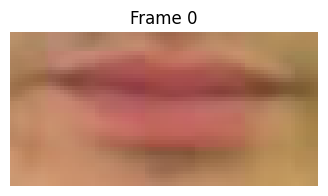

In [20]:
import matplotlib.pyplot as plt

def show_frames(frames, num_frames=1):
    """Displays a subset of extracted frames using matplotlib."""
    for i in range(min(num_frames, len(frames))):
        plt.figure(figsize=(4, 2))
        plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i}")
        plt.axis("off")
        plt.show()


show_frames(video_data[0])


### Modeling


In [21]:
def match_viseme_frames(video_frames, alignment_df):
    num_frames = video_frames.shape[0]

    visemes_per_frame = [[] for _ in range(num_frames)]

    for _, row in alignment_df.iterrows():
        start = max(0, int(row['start_frame']))
        end = min(num_frames - 1, int(row['end_frame']))
        visemes = row['encoded_visemes']

        for frame_idx in range(start, end + 1):
            visemes_per_frame[frame_idx].extend(visemes)

    return visemes_per_frame

In [22]:
def visemes_to_multihot_torch(visemes_per_frame,num_visemes=TOTAL_VISEMES):
    num_frames = len(visemes_per_frame)
    multi_hot = torch.zeros((num_frames, num_visemes), dtype=torch.float32)
    for i, visemes in enumerate(visemes_per_frame):
        multi_hot[i, visemes] = 1.0
    return multi_hot

In [23]:
class LipVisemeCNN(nn.Module):
    def __init__(self, num_visemes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * (FRAME_H//4) * (FRAME_W//4), 128)
        self.fc2 = nn.Linear(128, num_visemes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [24]:
all_frames_tensors = []
all_viseme_multihots = []

for frames, alignment_df in zip(video_data, alignment_data):
    frames_tensor = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0

    visemes_per_frame = match_viseme_frames(frames, alignment_df)
    viseme_tensor = visemes_to_multihot_torch(visemes_per_frame, TOTAL_VISEMES)

    all_frames_tensors.append(frames_tensor)
    all_viseme_multihots.append(viseme_tensor)

In [25]:
train_idxs = split_training(range(len(all_frames_tensors)), split='train')
val_idxs = split_training(range(len(all_frames_tensors)), split='val')

train_frames = [all_frames_tensors[i] for i in train_idxs]
train_labels = [all_viseme_multihots[i] for i in train_idxs]
val_frames = [all_frames_tensors[i] for i in val_idxs]
val_labels = [all_viseme_multihots[i] for i in val_idxs]

Set up a checkpoint to be saved when model outperforms previous

In [26]:
def save_checkpoint(model, optimizer, epoch, path='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")

In [27]:
def load_checkpoint(model, optimizer=None, path='checkpoint.pth', device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint.get('epoch', 0)
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    print(f"Loaded checkpoint '{path}' (epoch {start_epoch})")

    return model, optimizer, start_epoch, best_val_loss

In [28]:
def train_simple(model, train_frames, train_labels, val_frames, val_labels, epochs=EPOCHS, lr=LEARNING_RATE, device='cuda',start_epoch=0,best_val_loss=float('inf')):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(start_epoch,epochs):
        model.train()
        train_loss = 0.0

        for frames_tensor, viseme_tensor in zip(train_frames, train_labels):
            frames_tensor = frames_tensor.to(device)
            viseme_tensor = viseme_tensor.to(device)

            optimizer.zero_grad()
            outputs = model(frames_tensor)
            loss = criterion(outputs, viseme_tensor)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * frames_tensor.size(0)

        avg_train_loss = train_loss / sum(f.size(0) for f in train_frames)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frames_tensor, viseme_tensor in zip(val_frames, val_labels):
                frames_tensor = frames_tensor.to(device)
                viseme_tensor = viseme_tensor.to(device)
                outputs = model(frames_tensor)
                loss = criterion(outputs, viseme_tensor)
                val_loss += loss.item() * frames_tensor.size(0)

        avg_val_loss = val_loss / sum(f.size(0) for f in val_frames)
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}")

        # Save model if it is better than previous
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(model, optimizer, epoch + 1, path='checkpoint.pth')


## Results

Now we actually run the model and get our results

In [29]:
all_frames_tensors = []
all_viseme_multihots = []

for frames, alignment_df in zip(video_data, alignment_data):
    frames_tensor = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0
    visemes_per_frame = match_viseme_frames(frames, alignment_df)
    viseme_tensor = visemes_to_multihot_torch(visemes_per_frame, TOTAL_VISEMES)

    all_frames_tensors.append(frames_tensor)
    all_viseme_multihots.append(viseme_tensor)

In [30]:
indices = list(range(len(all_frames_tensors)))
train_indices = split_training(indices, split="train")
val_indices = split_training(indices, split="val")

train_frames = [all_frames_tensors[i] for i in train_indices]
train_labels = [all_viseme_multihots[i] for i in train_indices]
val_frames = [all_frames_tensors[i] for i in val_indices]
val_labels = [all_viseme_multihots[i] for i in val_indices]

In [31]:
model = LipVisemeCNN(num_visemes=TOTAL_VISEMES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
start_epoch = 0
checkpoint_path = 'checkpoint.pth'

# Load checkpoint before training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    model, optimizer, start_epoch, best_val_loss = load_checkpoint(
        model, optimizer, path=checkpoint_path, device=device)
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("Checkpoint not found, starting training from scratch.")



Loaded checkpoint 'checkpoint.pth' (epoch 15)
Resuming training from epoch 15


In [32]:
train_simple(model, train_frames, train_labels, val_frames, val_labels, epochs=EPOCHS, lr=LEARNING_RATE, device='cuda', start_epoch=start_epoch)

Epoch 16/50, Train Loss: 0.2253
Epoch 16/50, Val Loss: 0.2008
Checkpoint saved to checkpoint.pth
Epoch 17/50, Train Loss: 0.2022
Epoch 17/50, Val Loss: 0.1895
Checkpoint saved to checkpoint.pth
Epoch 18/50, Train Loss: 0.1930
Epoch 18/50, Val Loss: 0.1843
Checkpoint saved to checkpoint.pth
Epoch 19/50, Train Loss: 0.1864
Epoch 19/50, Val Loss: 0.1856
Epoch 20/50, Train Loss: 0.1811
Epoch 20/50, Val Loss: 0.1838
Checkpoint saved to checkpoint.pth
Epoch 21/50, Train Loss: 0.1769
Epoch 21/50, Val Loss: 0.1769
Checkpoint saved to checkpoint.pth
Epoch 22/50, Train Loss: 0.1733
Epoch 22/50, Val Loss: 0.1759
Checkpoint saved to checkpoint.pth
Epoch 23/50, Train Loss: 0.1701
Epoch 23/50, Val Loss: 0.1751
Checkpoint saved to checkpoint.pth
Epoch 24/50, Train Loss: 0.1671
Epoch 24/50, Val Loss: 0.1770
Epoch 25/50, Train Loss: 0.1638
Epoch 25/50, Val Loss: 0.1802
Epoch 26/50, Train Loss: 0.1621
Epoch 26/50, Val Loss: 0.1797
Epoch 27/50, Train Loss: 0.1601
Epoch 27/50, Val Loss: 0.1698
Checkpoint 

## Conclusion

There remains a few limitations and future steps that could be accomplished with more time. One of these is that I really wish I had a more visual representation of my results. Overall because of the lower processing power I have access to I cannot fully evaluate, but using more manual tests I found it to overall be not very accurate.
This leads on to one of the other limiations which was the continuity between frames. My plans were to use a system to allow continuity between frames because they are obviously directly influencing eachother, but I just ran out of time to effectively implement it. The full results section is definitely lacking but I unfortunately just couldn't get to it as well as I wanted.

Despite those limitations I am happy with this project as a whole. I knew it would be dificult so I am not that suprised I didn't quite reach all my goals.